In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score,classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


Read the dataset

In [2]:
path = '../Dataset/bank_customer.csv'
df = pd.read_csv(path)

In [3]:
df.head()

,Unnamed: 0,ID,Gender,Month_Income,Age,Region_Code,Occupation,Credit_Score,Loan_Status,Existing_Credit_Cards,Avg_Account_Balance,Account_Category,Tenure_with_Bank,Lead_Outcome
0,0,VBENBARO,Male,96345.0,29,254,Other,623,Yes,4,742366,X1,2,No
1,1,CCMEWNKY,Male,85640.0,43,268,Other,629,NaN,0,925537,X2,1,No
2,2,VK3KGA9M,Male,96345.0,31,270,Salaried,357,No,0,215949,X1,1,No
3,3,TT8RPZVC,Male,85640.0,29,272,Other,356,No,0,868070,X1,3,No
4,4,SHQZEYTZ,Female,42820.0,29,270,Other,572,No,0,657087,X1,3,No


In [4]:
#mapping the Account_Category	
category_mapping = {
    'X1': 'Savings Account',
    'X2': 'Current Account',
    'X3': 'Senior Citizens Account',
    'X4': 'Investment Account'
}

# Replace the values in the Account_Category column
df['Account_Category'] = df['Account_Category'].replace(category_mapping)

Data Gathering and Exploration

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             105000 non-null  int64  
 1   ID                     105000 non-null  object 
 2   Gender                 105000 non-null  object 
 3   Month_Income           102514 non-null  float64
 4   Age                    105000 non-null  int64  
 5   Region_Code            105000 non-null  int64  
 6   Occupation             102486 non-null  object 
 7   Credit_Score           105000 non-null  int64  
 8   Loan_Status            92511 non-null   object 
 9   Existing_Credit_Cards  105000 non-null  int64  
 10  Avg_Account_Balance    105000 non-null  int64  
 11  Account_Category       105000 non-null  object 
 12  Tenure_with_Bank       105000 non-null  int64  
 13  Lead_Outcome           105000 non-null  object 
dtypes: float64(1), int64(7), object(6)
m

In [7]:
missing_values = df.isna().sum().to_dict()

# Filter columns with missing values
columns_with_missing_values = {k: v for k, v in missing_values.items() if v > 0}

column_data_types = df.dtypes.to_dict()

numerical_missing = {k: v for k, v in columns_with_missing_values.items() if column_data_types[k] in ['int64', 'float64']}
categorical_missing = {k: v for k, v in columns_with_missing_values.items() if column_data_types[k] == 'object'}

print("Numerical columns with missing values:", numerical_missing)
print("Categorical columns with missing values:", categorical_missing)

Numerical columns with missing values: {'Month_Income': 2486}
Categorical columns with missing values: {'Occupation': 2514, 'Loan_Status': 12489}


Fill the missing values in the columns

In [8]:
for column in categorical_missing:
    if df[column].isnull().any():
        df[column] = df[column].fillna(df[column].mode()[0])

In [9]:
for column in numerical_missing:
    if df[column].isnull().any():
        df[column] = df[column].fillna(df[column].mean())

In [10]:
# df = df.dropna()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             105000 non-null  int64  
 1   ID                     105000 non-null  object 
 2   Gender                 105000 non-null  object 
 3   Month_Income           105000 non-null  float64
 4   Age                    105000 non-null  int64  
 5   Region_Code            105000 non-null  int64  
 6   Occupation             105000 non-null  object 
 7   Credit_Score           105000 non-null  int64  
 8   Loan_Status            105000 non-null  object 
 9   Existing_Credit_Cards  105000 non-null  int64  
 10  Avg_Account_Balance    105000 non-null  int64  
 11  Account_Category       105000 non-null  object 
 12  Tenure_with_Bank       105000 non-null  int64  
 13  Lead_Outcome           105000 non-null  object 
dtypes: float64(1), int64(7), object(6)
m

Drop unwanted columns

In [12]:
df = df.drop(['Unnamed: 0','ID'], axis=1)


Check for Imbalance

In [13]:
#checking for outliers
def check_outliers_iqr(df):
    outliers = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers_in_column = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        outliers[column] = outliers_in_column[column]
        
        print(f"Column: {column}")
        print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        print(f"Number of outliers in {column}: {len(outliers_in_column)}")
        print("*"*40)
        
    return outliers

outliers = check_outliers_iqr(df)


Column: Month_Income
Lower bound: -13087.5, Upper bound: 193092.5
Number of outliers in Month_Income: 5904
****************************************
Column: Age
Lower bound: -6.0, Upper bound: 90.0
Number of outliers in Age: 0
****************************************
Column: Credit_Score
Lower bound: -46.5, Upper bound: 1261.5
Number of outliers in Credit_Score: 0
****************************************
Column: Existing_Credit_Cards
Lower bound: -3.0, Upper bound: 5.0
Number of outliers in Existing_Credit_Cards: 8600
****************************************
Column: Avg_Account_Balance
Lower bound: -547428.0, Upper bound: 2522940.0
Number of outliers in Avg_Account_Balance: 6197
****************************************
Column: Tenure_with_Bank
Lower bound: -6.0, Upper bound: 18.0
Number of outliers in Tenure_with_Bank: 0
****************************************


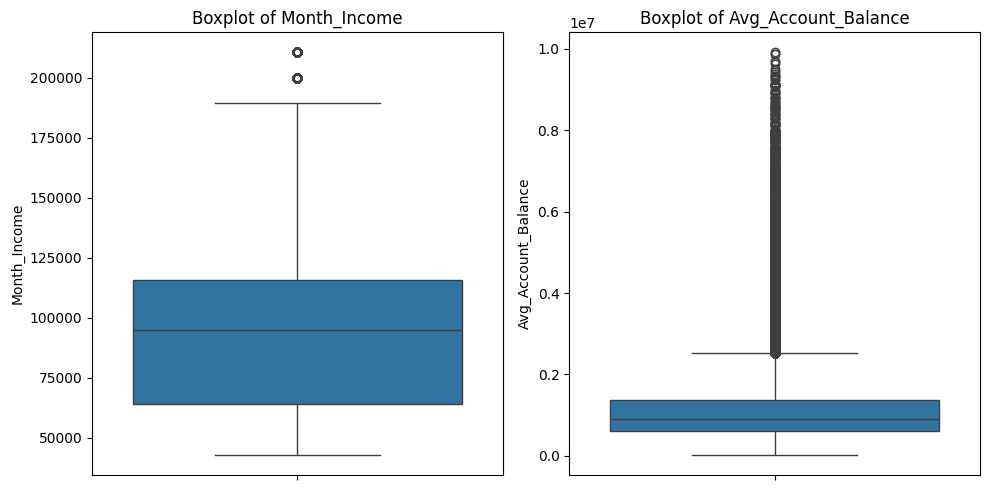

In [14]:
columns_with_outliers = ['Month_Income', 'Avg_Account_Balance']

plt.figure(figsize=(10, 5))

for i, column in enumerate(columns_with_outliers, 1):
    plt.subplot(1, len(columns_with_outliers), i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    
plt.tight_layout()
plt.show()

In [15]:
# Cap outliers in 'Avg_Account_Balance'
# df['Avg_Account_Balance'] = df['Avg_Account_Balance'].clip(lower=-546012.75, upper=2497021.25)

In [16]:
#selecting categorical columns

categorical_cols = df.select_dtypes(include=['object']).columns.to_list()
categorical_cols

['Gender', 'Occupation', 'Loan_Status', 'Account_Category', 'Lead_Outcome']

In [17]:
#selecting numerical columns

numerical_cols = df.select_dtypes(include=['float64','int64']).columns.to_list()
numerical_cols

['Month_Income',
 'Age',
 'Credit_Score',
 'Existing_Credit_Cards',
 'Avg_Account_Balance',
 'Tenure_with_Bank']

In [18]:
for column in categorical_cols:
    value_counts = df[column].value_counts()
    
    percentages = (value_counts / len(df)) * 100
    
    print(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
    print("-" * 40)

        Count  Percentage
Gender                   
Male    57546   54.805714
Female  47454   45.194286
----------------------------------------
               Count  Percentage
Occupation                      
Self_Employed  44541   42.420000
Salaried       30066   28.634286
Other          29343   27.945714
Entrepreneur    1050    1.000000
----------------------------------------
             Count  Percentage
Loan_Status                   
No           73920        70.4
Yes          31080        29.6
----------------------------------------
                         Count  Percentage
Account_Category                          
Savings Account          44338   42.226667
Senior Citizens Account  29191   27.800952
Current Account          29097   27.711429
Investment Account        2374    2.260952
----------------------------------------
              Count  Percentage
Lead_Outcome                   
No            63605    60.57619
Yes           41395    39.42381
------------------------

In [19]:
for column in numerical_cols:
    value_counts = df[column].value_counts()
    
    percentages = (value_counts / len(df)) * 100
    
    print(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
    print("-" * 40)

               Count  Percentage
Month_Income                    
85640.000000    8938    8.512381
42820.000000    8934    8.508571
107050.000000   8916    8.491429
74935.000000    8897    8.473333
64230.000000    8824    8.403810
96345.000000    8806    8.386667
53525.000000    8773    8.355238
210500.000000   2960    2.819048
199975.000000   2944    2.803810
136825.000000   2931    2.791429
147350.000000   2930    2.790476
126300.000000   2929    2.789524
105250.000000   2903    2.764762
189450.000000   2899    2.760952
168400.000000   2890    2.752381
94725.000000    2862    2.725714
115775.000000   2858    2.721905
84200.000000    2843    2.707619
157875.000000   2840    2.704762
73675.000000    2830    2.695238
178925.000000   2807    2.673333
101550.327858   2486    2.367619
----------------------------------------
     Count  Percentage
Age                   
28    6324    6.022857
29    5683    5.412381
27    5585    5.319048
30    4601    4.381905
26    3865    3.680952
..    

Handle the imbalance columns

In [20]:
def categorize_tenure(value):
    if value in [1, 2, 3, 4]:
        return value
    elif value >= 5 and value <10:
        return '5-10'
    elif value >= 10:
        return '10+'

# Apply the function to create a new column with categorized values
df['Tenure_with_Bank_Categorized'] = df['Tenure_with_Bank'].apply(categorize_tenure)

# Update the original column with the new categorized values
df['Tenure_with_Bank'] = df['Tenure_with_Bank_Categorized']

# Drop the temporary column
df.drop(columns=['Tenure_with_Bank_Categorized'], inplace=True)

print(df['Tenure_with_Bank'].value_counts())

Tenure_with_Bank
5-10    31506
10+     22530
2       12796
1       12754
3       12747
4       12667
Name: count, dtype: int64


In [21]:
# handling Existing_Credit_Cards
df['Existing_Credit_Cards'] = df['Existing_Credit_Cards'].apply(lambda x: 0 if x == 0 else 1)

print(df['Existing_Credit_Cards'].value_counts())

Existing_Credit_Cards
0    73920
1    31080
Name: count, dtype: int64


In [22]:
# # Define Loan_Status as the target to be balanced
# ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# # Resample based on Loan_Status
# X_res, y_res = ros.fit_resample(df.drop('Loan_Status', axis=1), df['Loan_Status'])

# # Combine the resampled target back with the original features
# df_resampled = pd.concat([pd.DataFrame(X_res, columns=df.drop('Loan_Status', axis=1).columns), pd.DataFrame(y_res, columns=['Loan_Status'])], axis=1)

# print(df_resampled['Loan_Status'].value_counts())

Exploratory Data Analysis (EDA)


In [23]:
print("\nStatistical summary of the dataset")
df.describe()


Statistical summary of the dataset


,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance
count,105000.000000,105000.000000,105000.000000,105000.000000,1.050000e+05
mean,101550.327858,43.875381,602.642581,0.296000,1.134120e+06
std,44996.550975,14.873280,180.611716,0.456493,8.663714e+05
min,42820.000000,24.000000,300.000000,0.000000,2.259700e+04
25%,64230.000000,30.000000,444.000000,0.000000,6.039600e+05
50%,94725.000000,43.000000,590.000000,0.000000,8.964700e+05
75%,115775.000000,54.000000,771.000000,1.000000,1.371552e+06
max,210500.000000,85.000000,900.000000,1.000000,9.908858e+06


In [24]:
sns.set(style="whitegrid")

# Function to plot distributions
def plot_distribution(column):
    plt.figure(figsize=(10, 5))
    if df[column].dtype == 'object':
        sns.countplot(x=column, data=df, palette='viridis')
        plt.title(f'Distribution of {column}')
    else:
        sns.histplot( df[column], bins=30, kde=True, color='skyblue')
        plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


# Function to plot count plot by target
def plot_by_target(column, target_column='Lead_Outcome'):
    plt.figure(figsize=(10, 5))
    if df[column].dtype == 'object':
        sns.countplot(x=column, hue=target_column, data=df, palette='Set2')
        plt.title(f'{column} Distribution by {target_column}')
    else:
        sns.boxplot(x=target_column, y=column, data=df, palette='Set2')
        plt.title(f'{column} Distribution by {target_column}')
    plt.xlabel(column)
    plt.ylabel('Count' if df[column].dtype == 'object' else column)
    plt.show()

Gender

C:\Users\user\AppData\Local\Temp\ipykernel_11376\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


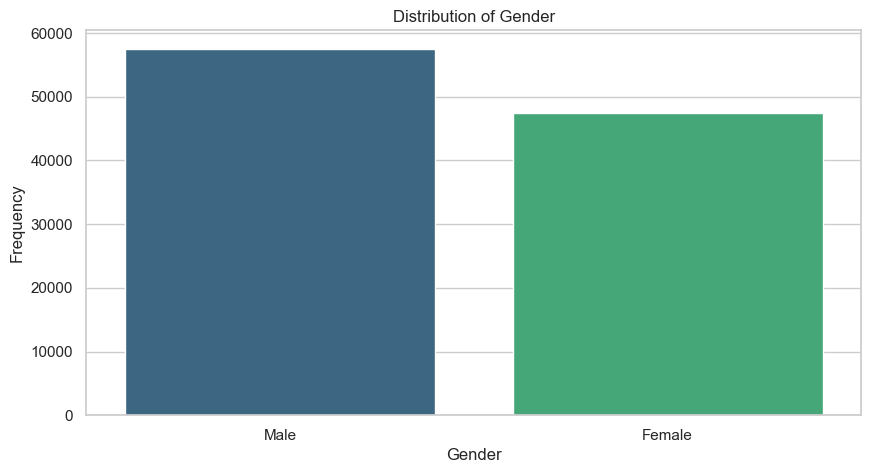

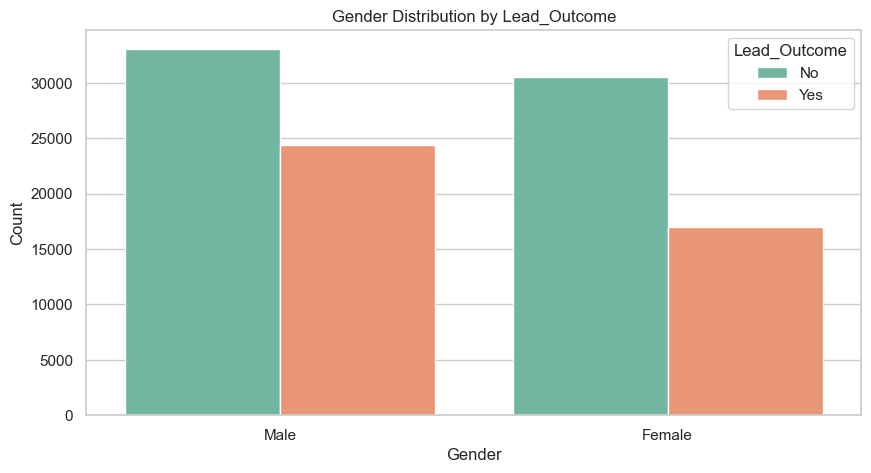

In [25]:
plot_distribution('Gender')
plot_by_target('Gender')

Month_Income

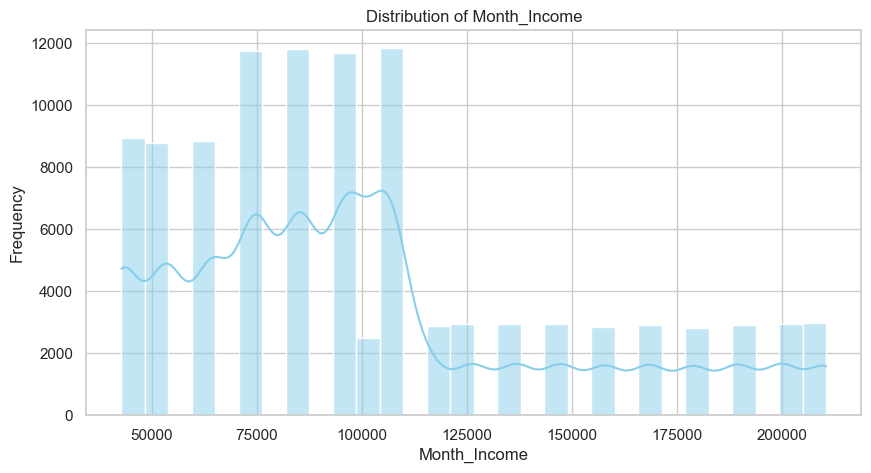

C:\Users\user\AppData\Local\Temp\ipykernel_11376\3294662204.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_column, y=column, data=df, palette='Set2')


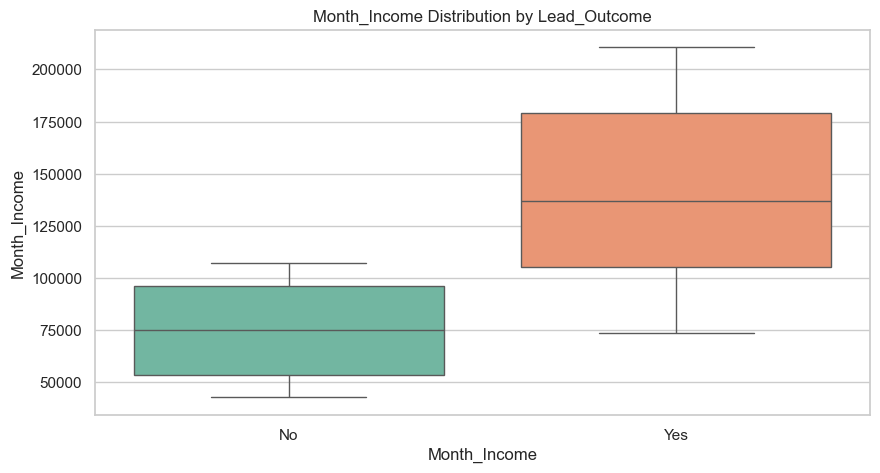

In [26]:
plot_distribution('Month_Income')
plot_by_target('Month_Income')

Age

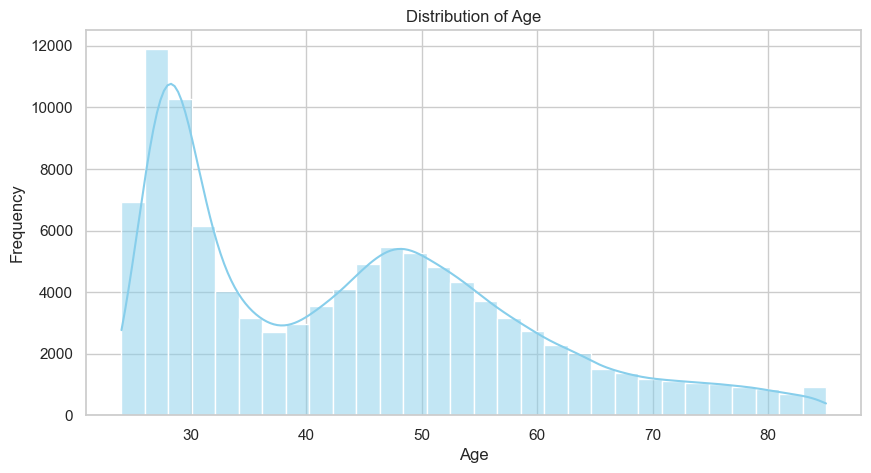

C:\Users\user\AppData\Local\Temp\ipykernel_11376\3294662204.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_column, y=column, data=df, palette='Set2')


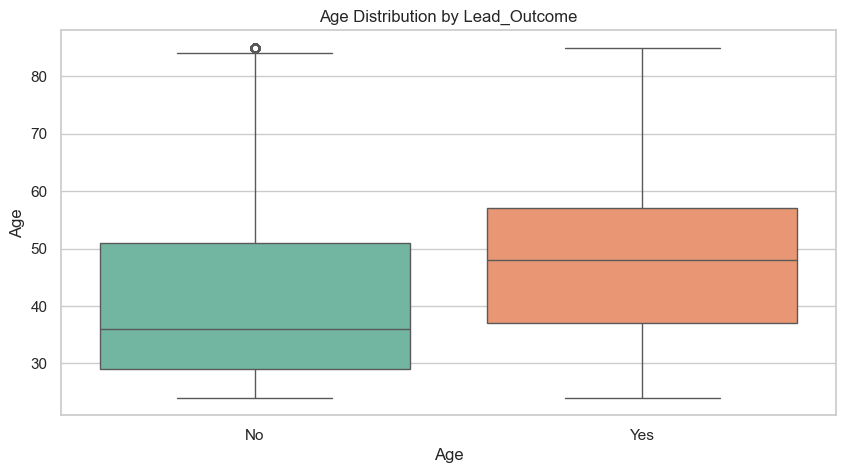

In [27]:
plot_distribution('Age')
plot_by_target('Age')

Occupation

C:\Users\user\AppData\Local\Temp\ipykernel_11376\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


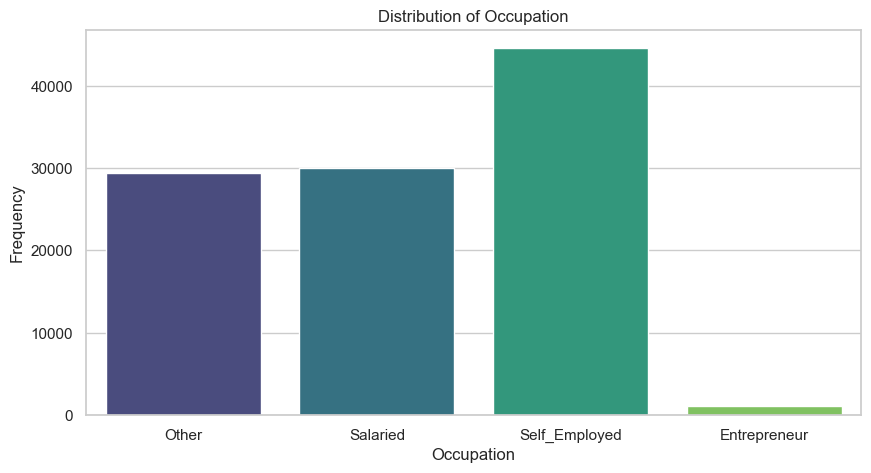

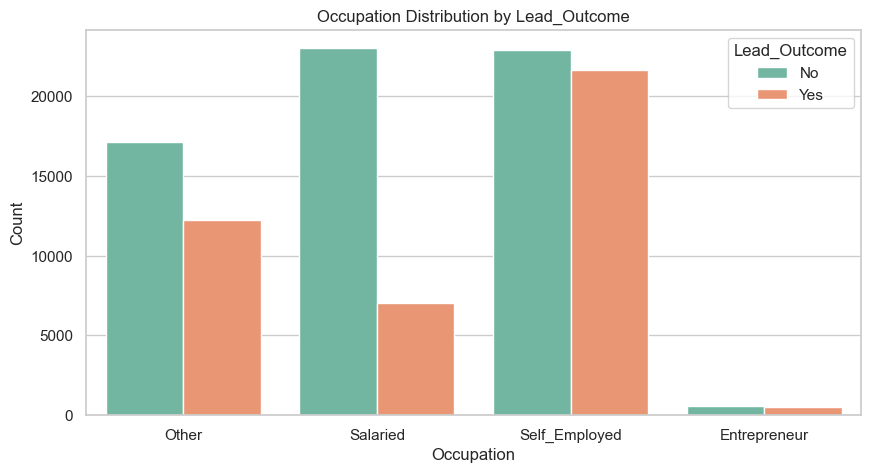

In [28]:
plot_distribution('Occupation')
plot_by_target('Occupation')

Loan_Status

C:\Users\user\AppData\Local\Temp\ipykernel_11376\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


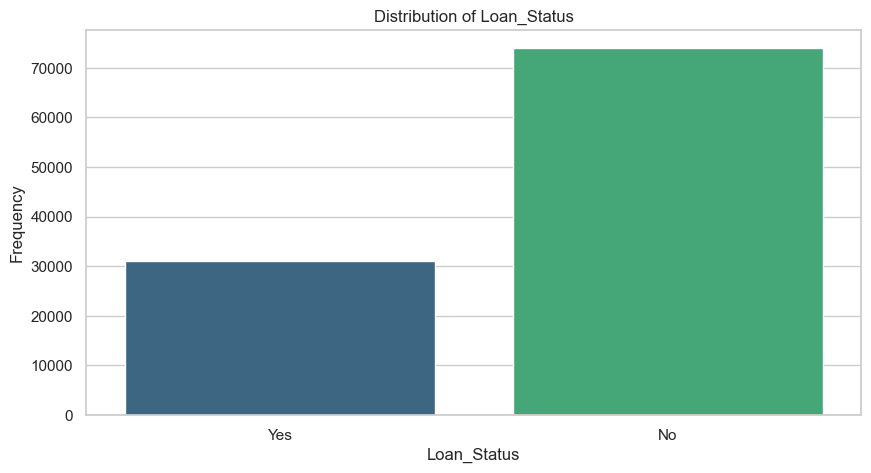

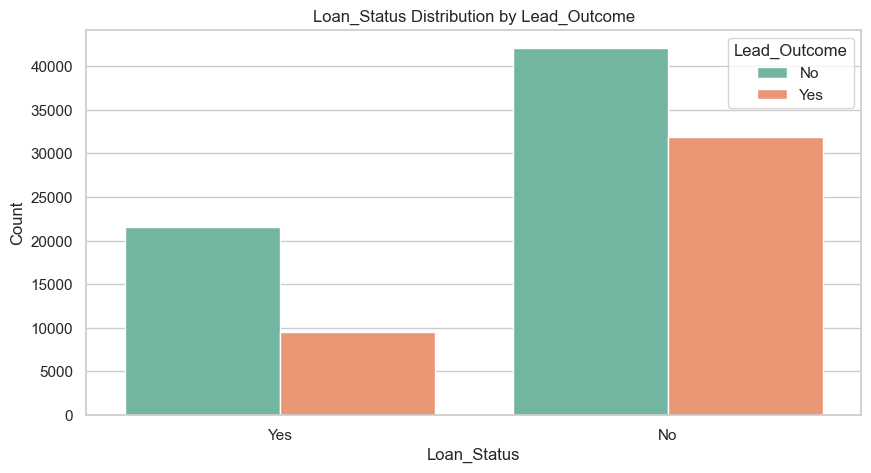

In [29]:
plot_distribution('Loan_Status')
plot_by_target('Loan_Status')

Existing_Credit_Cards

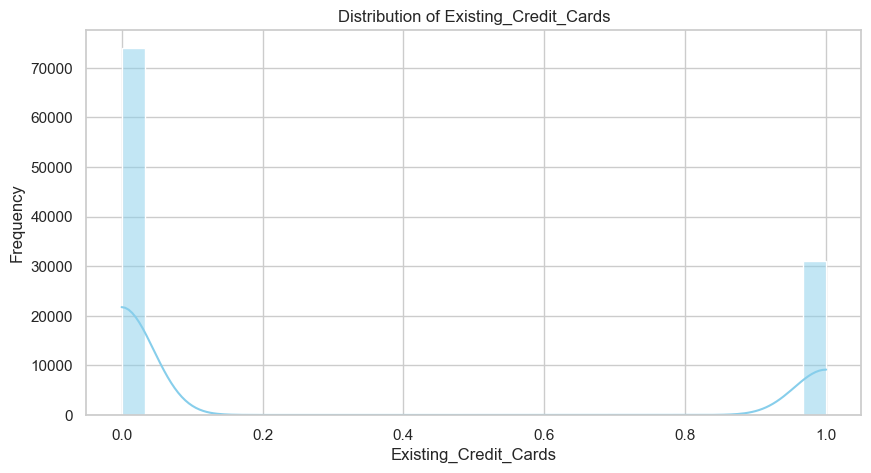

C:\Users\user\AppData\Local\Temp\ipykernel_11376\3294662204.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_column, y=column, data=df, palette='Set2')


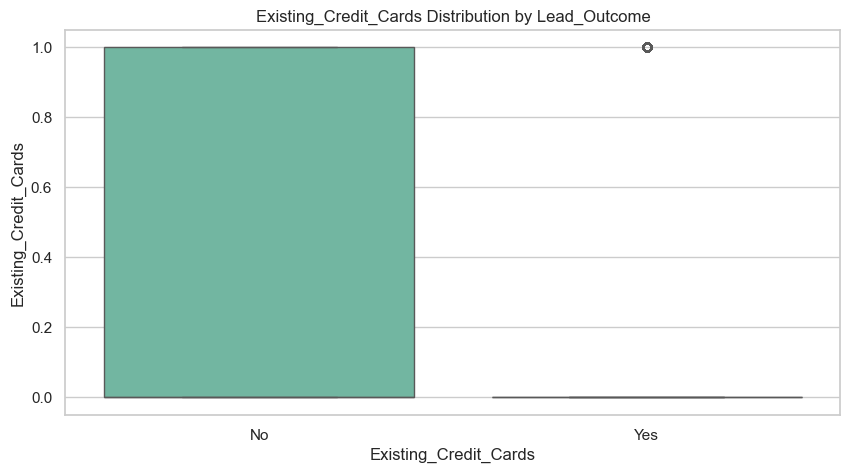

In [30]:
plot_distribution('Existing_Credit_Cards')
plot_by_target('Existing_Credit_Cards')

Account_Category

C:\Users\user\AppData\Local\Temp\ipykernel_11376\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


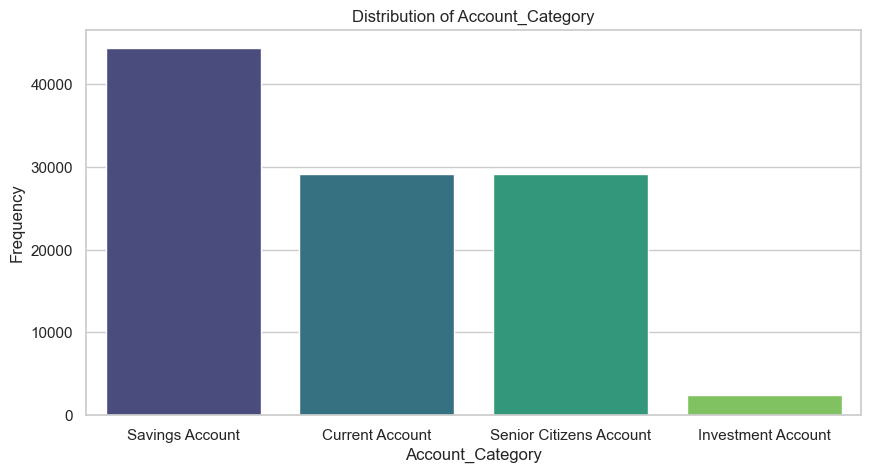

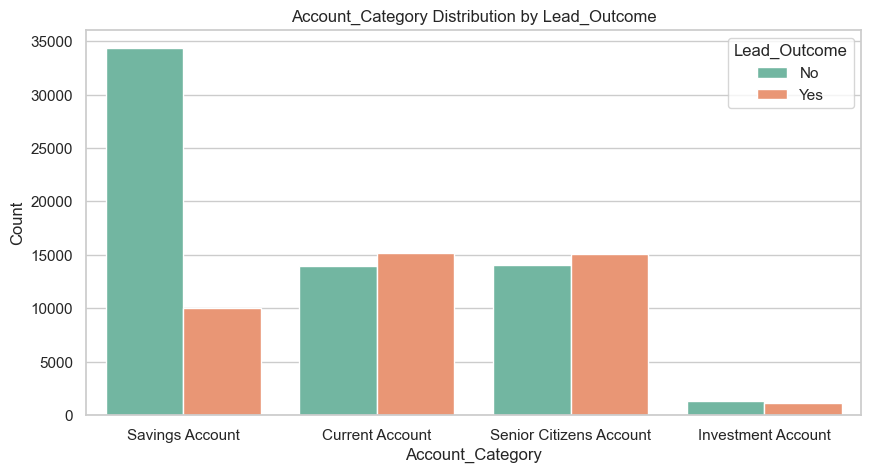

In [31]:
plot_distribution('Account_Category')
plot_by_target('Account_Category')

Tenure_with_Bank

C:\Users\user\AppData\Local\Temp\ipykernel_11376\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


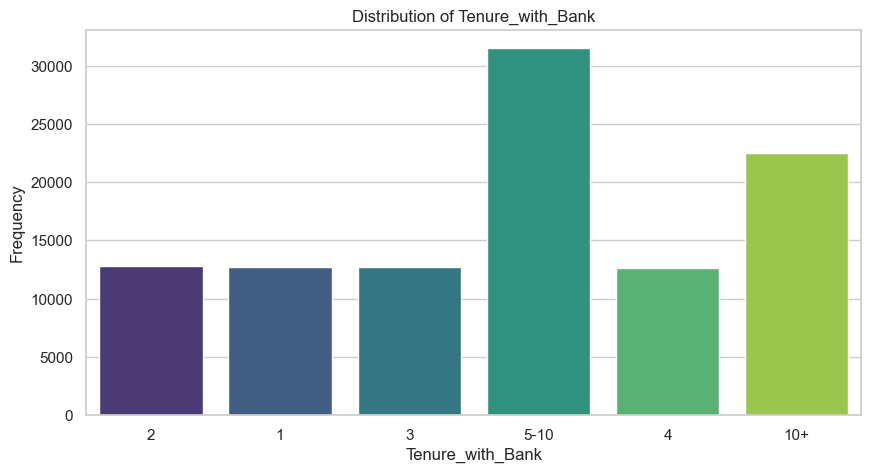

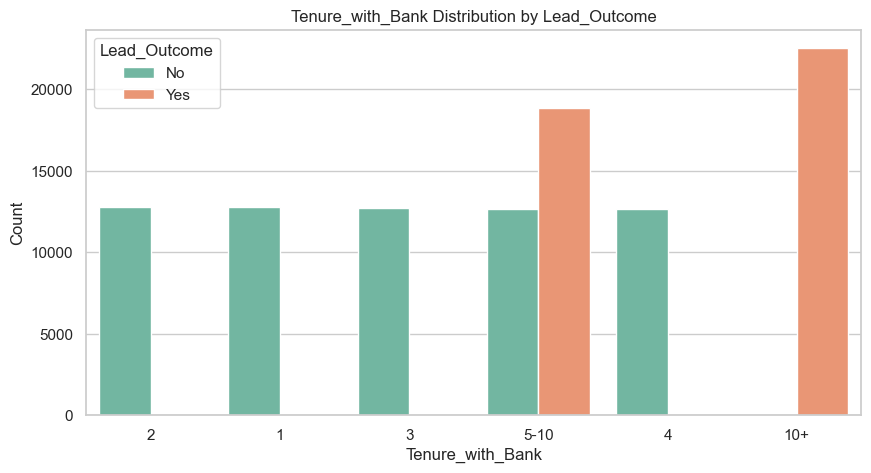

In [32]:
plot_distribution('Tenure_with_Bank')
plot_by_target('Tenure_with_Bank')

Lead_Outcome

C:\Users\user\AppData\Local\Temp\ipykernel_11376\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


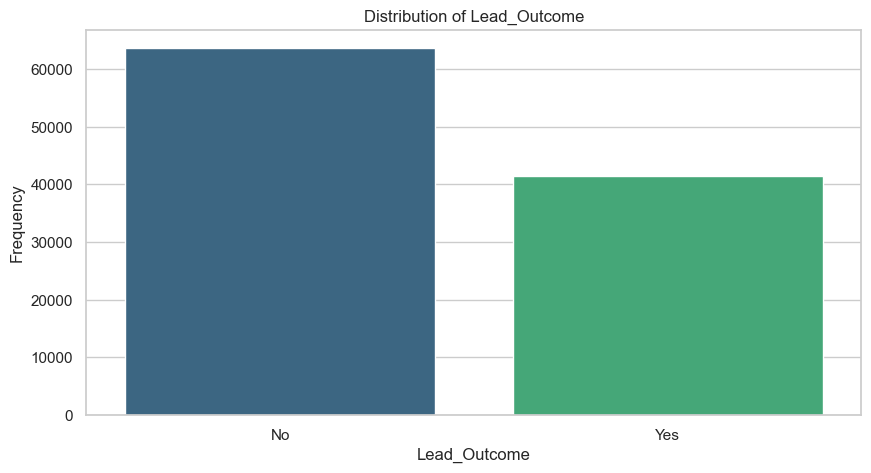

In [33]:
plot_distribution('Lead_Outcome')

Encoding the columns 

In [34]:
# #Convert categorical features into numerical values

# # Initialize the LabelEncoder
# label_encoders = {}
# for col in categorical_cols:
#     label_encoder = LabelEncoder()
#     df[col] = label_encoder.fit_transform(df[col])
#     label_encoders[col] = label_encoder

#     # Display mapping for this column
#     print(f"\nMapping for {col}:")
#     for class_index, class_label in enumerate(label_encoder.classes_):
#         print(f"{class_label}: {class_index}")

df['Lead_Outcome']=df['Lead_Outcome'].apply(lambda x : 1 if x=='Yes' else 0) 
df = pd.get_dummies(df)
print(df.columns)

df.to_csv('../Dataset/processed_training_data.csv', index=False)

Index(['Month_Income', 'Age', 'Credit_Score', 'Existing_Credit_Cards',
       'Avg_Account_Balance', 'Lead_Outcome', 'Gender_Female', 'Gender_Male',
       'Occupation_Entrepreneur', 'Occupation_Other', 'Occupation_Salaried',
       'Occupation_Self_Employed', 'Loan_Status_No', 'Loan_Status_Yes',
       'Account_Category_Current Account',
       'Account_Category_Investment Account',
       'Account_Category_Savings Account',
       'Account_Category_Senior Citizens Account', 'Tenure_with_Bank_1',
       'Tenure_with_Bank_2', 'Tenure_with_Bank_3', 'Tenure_with_Bank_4',
       'Tenure_with_Bank_10+', 'Tenure_with_Bank_5-10'],
      dtype='object')


In [35]:
df.head()

,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance,Lead_Outcome,Gender_Female,Gender_Male,Occupation_Entrepreneur,Occupation_Other,...,Account_Category_Current Account,Account_Category_Investment Account,Account_Category_Savings Account,Account_Category_Senior Citizens Account,Tenure_with_Bank_1,Tenure_with_Bank_2,Tenure_with_Bank_3,Tenure_with_Bank_4,Tenure_with_Bank_10+,Tenure_with_Bank_5-10
0,96345.0,29,623,1,742366,0,False,True,False,True,...,False,False,True,False,False,True,False,False,False,False
1,85640.0,43,629,0,925537,0,False,True,False,True,...,True,False,False,False,True,False,False,False,False,False
2,96345.0,31,357,0,215949,0,False,True,False,False,...,False,False,True,False,True,False,False,False,False,False
3,85640.0,29,356,0,868070,0,False,True,False,True,...,False,False,True,False,False,False,True,False,False,False
4,42820.0,29,572,0,657087,0,True,False,False,True,...,False,False,True,False,False,False,True,False,False,False


Train the model

In [36]:
X = df.drop('Lead_Outcome', axis=1).values  # Features
y = df['Lead_Outcome'].values  # Target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [37]:
# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

# Parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.1, 1, 10]
}

# Initialize models
models = {
    'Random Forest': (RandomForestClassifier(), param_grid_rf, GridSearchCV),
    'Logistic Regression': (LogisticRegression(class_weight='balanced'), param_grid_lr, GridSearchCV),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, RandomizedSearchCV)
}

In [38]:
# Perform hyperparameter tuning with K-Fold Cross Validation
best_models = {}

for name, (model, param_grid, search_method) in models.items():
    print("-" * 100)
    print(f"Starting hyperparameter tuning for {name}...")
    
    # For GridSearchCV or RandomizedSearchCV based on the model
    if search_method == GridSearchCV:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=2)
    else:
        grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=kfold, n_jobs=-1, verbose=2, random_state=42)
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}")
    print("-" * 100)
    
    best_models[name] = grid_search.best_estimator_

----------------------------------------------------------------------------------------------------
Starting hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Random Forest: 1.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Starting hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score for Logistic Regression: 0.8558367346938776
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Starting hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for XGBoost: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best score for XGBoost: 1.0
----------------------------------------------------------------------------------------------------


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:23:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [39]:
# Evaluate the tuned models
def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        print(f'\nPerformance Report for {name} (Tuned):\n')
        
        # Predict the outcomes
        y_pred = model.predict(X_test)
        
        # Compute and print accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {accuracy:.4f}')

        # Compute and print classification report
        print('Classification Report:')
        print(classification_report(y_test, y_pred))

# Call the function to evaluate the best models
evaluate_models(best_models, X_test, y_test)


Performance Report for Random Forest (Tuned):

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19081
           1       1.00      1.00      1.00     12419

    accuracy                           1.00     31500
   macro avg       1.00      1.00      1.00     31500
weighted avg       1.00      1.00      1.00     31500


Performance Report for Logistic Regression (Tuned):

Accuracy: 0.9279
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     19081
           1       0.88      0.94      0.91     12419

    accuracy                           0.93     31500
   macro avg       0.92      0.93      0.93     31500
weighted avg       0.93      0.93      0.93     31500


Performance Report for XGBoost (Tuned):

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00    

Test MAE, MSE, and R² for Logistic Regression

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = best_models['Logistic Regression'].predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 0.07212698412698412
Mean Squared Error: 0.07212698412698412


Save the model


In [41]:
import joblib

# Save the model
joblib.dump(best_models['Logistic Regression'], '../TrainedModels/Logistic_Regression_model.pkl')

['../TrainedModels/Logistic_Regression_model.pkl']

In [42]:
# Load the model
loaded_model = joblib.load('../TrainedModels/Logistic_Regression_model.pkl')

Make a prediction

In [43]:
# Example new data
new_data = pd.DataFrame({
    'Gender': ['Male'],
    'Month_Income': [200000],
    'Age': [35],
    'Occupation': ['Entrepreneur'],
    'Credit_Score': [350],
    'Loan_Status': ['No'],
    'Existing_Credit_Cards': [2],
    'Avg_Account_Balance': [100000],
    'Account_Category': ['Investment Account'],
    'Tenure_with_Bank': [1]
})

new_data_encoded = pd.get_dummies(new_data)

all_columns = df.columns.drop('Lead_Outcome') 
new_data = new_data_encoded.reindex(columns=all_columns, fill_value=0)


In [44]:
new_data

,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance,Gender_Female,Gender_Male,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,...,Account_Category_Current Account,Account_Category_Investment Account,Account_Category_Savings Account,Account_Category_Senior Citizens Account,Tenure_with_Bank_1,Tenure_with_Bank_2,Tenure_with_Bank_3,Tenure_with_Bank_4,Tenure_with_Bank_10+,Tenure_with_Bank_5-10
0,200000,35,350,2,100000,0,True,True,0,0,...,0,True,0,0,0,0,0,0,0,0


In [45]:
# Make predictions
predictions = loaded_model.predict(new_data)

predictions = ['Yes' if pred == 1 else 'No' for pred in predictions]

print(f'Predicted Lead Outcome: {predictions[0]}')


Predicted Lead Outcome: Yes


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
